<h1><center>Few-shot - Practical session</center></h1>

In this practical session, you will perform few-shot classification on the MiniImagenet dataset. Here we only focus on the classification aspect of the problem, and not on the training aspect. For this reaon, features are directly provided, so you don't need to train neural networks.

Below, you will first find a bunch of pre-written codes, i.e., imports, constants and a few basic functions. Quickly read the constant and function headers to know what you already have access to. Functions to complete will be provided later in this document.

<h1><center>Given codes</center></h1>

<h2>Imports</h2>

In [1]:
import argparse
import torch
import torch.nn.functional as F
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
import sklearn.metrics

In [2]:
matplotlib.rc("font", size=16)
display(HTML("<style>.container { width:95% !important; }</style>"))

<h2>Constants</h2>

In [3]:
parser = argparse.ArgumentParser()

In [4]:
_ = parser.add_argument("--features_dir",
                        help="Directory containing the features",
                        type=str,
                        default="./data/")

In [5]:
_ = parser.add_argument("--backbone",
                        help="Chosen backbone used to generate the features",
                        type=int,
                        choices=[1, 2, 3],
                        default=1)

In [6]:
_ = parser.add_argument("--train_val_test_split",
                        help="Dimensions of the sets in feature files",
                        type=tuple,
                        default=(64, 16, 20))

In [7]:
_ = parser.add_argument("--nb_ways",
                        help="Number of ways for few-shot",
                        type=int,
                        default=5)

In [8]:
_ = parser.add_argument("--nb_shots",
                        help="Number of shots for few-shot",
                        type=int,
                        default=1)

In [9]:
_ = parser.add_argument("--nb_queries",
                        help="Number of queries for few-shot",
                        type=int,
                        default=15)

In [10]:
_ = parser.add_argument("--nb_runs",
                        help="Number of runs to perform",
                        type=int,
                        default=10000)

In [11]:
_ = parser.add_argument("--random_seed",
                        help="Random seed to initialize the runs",
                        type=int,
                        default=0)

In [12]:
try :
    get_ipython()
    ARGS = parser.parse_args(args=[])
except :
    ARGS = parser.parse_args()

<h2>Cuda</h2>

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h2>Functions</h2>

In [14]:
def compute_accuracy (ground_truth, prediction) :
    
    ###########################################################################################################
    """
        Returns accuracy of a prediction.
        In:
            * ground_truth: Expected labels.
            * prediction: Predicted labels.
        Out:
            * accuracy: Percentage of correct predictions.
    """
    ###########################################################################################################
    
    # Compute accuracy
    accuracy = ((prediction == ground_truth).float().sum() / len(prediction)).item()
    
    # Done
    return accuracy

In [15]:
def compute_accuracy_stats (all_accuracies) :

    ###########################################################################################################
    """
        Returns the mean and 95% confidence intervals for a list of results.
        In:
            * all_accuracies: List of accuracies to use.
        Out:
            * mean_accuracy: Average accuracy.
            * confidence_95: 95% confidence interval.
    """
    ###########################################################################################################

    # Compute stats
    mean_accuracy = np.mean(all_accuracies)
    confidence_95 = 1.96 * np.std(all_accuracies) / np.sqrt(len(all_accuracies))
    
    # Done
    return mean_accuracy, confidence_95

In [16]:
def generate_few_shot_data (data, counts_per_class, nb_ways, nb_shots, nb_queries, fixed_ways=None) :

    ###########################################################################################################
    """
        Generates shots and queries from data tensor (label, data, feature).
        In:
            * data: Data from which to get random samples.
            * counts_per_class: Number of data available per class of the dataset.
            * nb_ways: Number of ways.
            * nb_shots: Number of shots.
            * nb_queries: Number of queries.
            * fixed_ways: Allows to randomly draw shots for the chosen fixed ways.
        Out:
            * ways: Ways used.
            * x_shots: Labeled data.
            * ix_shots: Indices of labeled data.
            * i_shots: Associated labels.
            * x_queries: Unlabeled data.
            * ix_queries: Indices of unlabeled data.
            * i_queries: Associated labels to predict.
    """
    ###########################################################################################################
    
    # Choose ways
    if fixed_ways is not None :
        ways = fixed_ways
    else :
        ways = np.random.choice(data.shape[0], nb_ways, False)
    
    # Get random shots/queries indices
    y_shots = [way for way in ways for _ in range(nb_shots)]
    y_queries = [way for way in ways for _ in range(nb_queries)]
    ix_shots = []
    ix_queries = []
    for way in ways :
        shots_queries = np.random.choice(counts_per_class[way], nb_shots + nb_queries, False).tolist()
        ix_shots += shots_queries[:nb_shots]
        ix_queries += shots_queries[nb_shots:]
    
    # Get actual data in addition to the indices
    x_shots = torch.stack([data[y_shots[i], ix_shots[i], :] for i in range(len(ix_shots))])
    x_queries = torch.stack([data[y_queries[i], ix_queries[i], :] for i in range(len(ix_queries))])
    
    # Additional type conversions
    ways = torch.tensor(ways)
    ix_shots = torch.tensor(ix_shots)
    y_shots = torch.tensor(y_shots)
    ix_queries = torch.tensor(ix_queries)
    y_queries = torch.tensor(y_queries)
    
    # Done
    return ways, x_shots, ix_shots, y_shots, x_queries, ix_queries, y_queries

In [17]:
def plot_matrix (matrix, rows_labels="", cols_labels="", rows_title="", cols_title="", title="", colorbar=False, round_values=None, file_name=None) :

    ###########################################################################################################
    """
        Plots a matrix.
        --
        In:
            * matrix: Matrix to plot.
            * rows_labels: Labels associated with the rows.
            * cols_labels: Labels associated with the columns.
            * title: Figure title.
            * colorbar: Set to True to plot a colorbar.
            * round_values: Set to >= 0 to plot values in matrix cells.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################
    
    # Plot matrix
    dimensions = (20, 20 * matrix.shape[0] / matrix.shape[1]) if matrix.shape[0] < matrix.shape[1] else (20 * matrix.shape[1] / matrix.shape[0], 20)
    figure, axis = plt.subplots(figsize=dimensions)
    cax = axis.matshow(matrix)
    
    # Add colorbar
    if colorbar :
        figure.colorbar(cax)
    
    # Add values
    if round_values is not None :
        color_change_threshold = 0.5 * (np.max(matrix) + np.min(matrix))
        for i in range(matrix.shape[0]) :
            for j in range(matrix.shape[1]) :
                value = round(matrix[i, j], round_values)
                if value == int(value) :
                    value = int(value)
                color = "black" if matrix[i, j] > color_change_threshold else "white"
                axis.text(j, i, str(value), va="center", ha="center", color=color)
    
    # Plot
    plt.title(title)
    plt.yticks(range(matrix.shape[0]))
    plt.ylabel(rows_title)
    plt.gca().set_yticklabels(rows_labels)
    plt.xticks(range(matrix.shape[1]))
    plt.xlabel(cols_title)
    plt.gca().set_xticklabels(cols_labels)
    plt.tight_layout()
    plt.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

In [18]:
def plot_points (xs, ys, legends=[], styles=[], lines=[], xlabel="", ylabel="", title="", file_name=None) :
    
    ###########################################################################################################
    """
        Plots multiple points.
        --
        In:
            * xs: X coordinates.
            * ys: Y coordinates.
            * legends: Legends to associate with the sets of points.
            * styles: Styles of the set of points.
            * lines: Custom lines to add as (x0, y0, x1, y1, style) tuples.
            * xlabel: X axis label.
            * ylabel: Y axis label.
            * title: Figure title.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################
    
    # Plot
    figure = plt.figure(figsize=(20, 10), constrained_layout=True)
    for i in range(len(ys)) :
        actual_legend = "" if len(legends) == 0 else legends[i]
        actual_styles = None if len(styles) == 0 else styles[i]
        plt.scatter(xs[i], ys[i], c=actual_styles, label=actual_legend)
    for line in lines :
        plt.plot([line[0], line[2]], [line[1], line[3]], line[4])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if len(legends) > 0 :
        plt.legend()
    plt.title(title)
    figure.gca().spines["right"].set_visible(False)
    figure.gca().spines["top"].set_visible(False)
    plt.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

In [19]:
def set_seed (seed) :
    
    ###########################################################################################################
    """
        Fixes all possible seeds.
        In:
            * seed: Seed value.
        Out:
            * None.
    """
    ###########################################################################################################
    
    # Compute a random value based on the global seed to act as starting point
    # We remove the number of runs since we use random seeds to always generate the same runs
    np.random.seed(ARGS.random_seed)
    init = np.random.randint(2**32 - 1 - ARGS.nb_runs)
    
    # Random libs seeds
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(init + seed)
    torch.cuda.manual_seed_all(init + seed)
    np.random.seed(init + seed)
    random.seed(init + seed)

<h1><center>Few-shot classification</center></h1>

The goal of this part is to maximize the average performance (over 10k random runs) of a few-shot classifier.

First, let's load the provided features. These features are tensors of dimension (X, Y, Z), where X is the number of classes, Y is the number of data points per class, and Z is the feature size. We have provided you 3 feature tensors, that have been generated using 3 different backbones.

In [20]:
# Load features
features = torch.load(ARGS.features_dir + os.path.sep + "minifeatures" + str(ARGS.backbone) + ".pt11", map_location=DEVICE)
train_set = features[:ARGS.train_val_test_split[0]]
val_set = features[ARGS.train_val_test_split[0]:ARGS.train_val_test_split[0]+ARGS.train_val_test_split[1]]
test_set = features[ARGS.train_val_test_split[0]+ARGS.train_val_test_split[1]:]

# With this dataset, we have the same number of data points per class
test_set_counts = [test_set.shape[1]] * test_set.shape[0]

<u><b>TODO:</b></u> Preprocess the features to improve performance (you can skip this first and come back to fill this cell later).

In [21]:
def preprocess (vectors, train_vectors, operations="") :
    
    ###########################################################################################################
    """
        Preprocesses vectors as indicated.
        In:
            * vectors: Vectors to preprocess.
            * train_vectors: Reference vectors for preprocessing.
            * operations: String describing the preprocessing steps to perform (e.g., 'CH', 'HCH').
        Out:
            * preprocessed_vectors: Preprocessed vectors.
    """
    ###########################################################################################################
    
    # Iterate over preprocessing string
    preprocessed_vectors = vectors.clone()
    preprocessed_train = train_vectors.clone()
    for operation in operations :
        
        # Project on hypersphere
        if operation == 'H' :
            preprocessed_vectors /= torch.norm(preprocessed_vectors, dim=-1, keepdim=True)
            preprocessed_train /= torch.norm(preprocessed_train, dim=-1, keepdim=True)
        
        # Center vectors around train vectors mean
        elif operation == 'C' :
            train_mean = torch.mean(preprocessed_train, dim=list(range(len(preprocessed_train.shape) - 1)))

            for i in range(len(preprocessed_vectors.shape) - len(train_mean.shape)) :
                train_mean.unsqueeze(0)

            preprocessed_vectors -= train_mean
            preprocessed_train -= train_mean
            
        # Error
        else :
            raise Exception("Invalid operation chosen: %s" % operation)
        
    # Done
    return preprocessed_vectors

In [22]:
# Preprocess
test_set = preprocess(test_set, train_set, "CH")

The code below is a generic function that will perform few-shot classification, averaged over multiple runs. In this code, we also compute the confusion matrix between test set classes.

In [23]:
def make_runs (test_set, test_set_counts, setting="inductive", fixed_ways=None, compute_confusion_matrix=False) :
    
    ###########################################################################################################
    """
        Performs projections and classifications.
        In:
            * test_set: Set from which to get the shots/queries.
            * test_set_counts: Number of data available per class of the test set.
            * setting: Inductive or transductive.
            * fixed_ways: Allows to randomly draw shots for the chosen fixed ways.
            * compute_confusion_matrix: Indicates if we compute the confusion matrix for all runs.
        Out :
            * all_accuracies: Accuracies obtained for all runs.
            * global_confusion_matrix: Confusion matrix obtained across all runs.
    """
    ###########################################################################################################

    # Generate runs
    all_accuracies = []
    global_confusion_matrix = np.zeros((test_set.shape[0], test_set.shape[0])) if compute_confusion_matrix else None
    for run in range(ARGS.nb_runs) :

        # Generate problem
        set_seed(run)
        ways, x_shots, ix_shots, y_shots, x_queries, ix_queries, y_queries = generate_few_shot_data(test_set, test_set_counts, ARGS.nb_ways, ARGS.nb_shots, ARGS.nb_queries, fixed_ways)

        # Solve the problem
        if setting == "inductive" :
            estimated_y_queries = nearest_class_mean(ways, x_shots, y_shots, x_queries)
        elif setting == "transductive" :
            estimated_y_queries = soft_k_means(ways, x_shots, y_shots, x_queries)
        else :
            raise Exception("Invalid setting chosen: %s" % ARGS.setting)
        
        # Verify accuracy
        accuracy = compute_accuracy(y_queries, estimated_y_queries)
        all_accuracies.append(accuracy)
    
        # Compute confusion matrix
        if compute_confusion_matrix or run in runs_to_plot :
            confusion_matrix = sklearn.metrics.confusion_matrix(y_queries, estimated_y_queries, labels=ways)
            if compute_confusion_matrix :
                for i in range(confusion_matrix.shape[0]) :
                    for j in range(confusion_matrix.shape[1]) :
                        global_confusion_matrix[ways[i], ways[j]] += confusion_matrix[i, j]
        
    # Done
    return all_accuracies, global_confusion_matrix

Let us work in inductive setting first. For recall, in this setting, queries cannot be used to improve the classification. The simplest classifier that can be used is a nearest mean classifier (NCM). You can find a description of that classifier here for instance: https://arxiv.org/abs/2201.09699.

<u><b>TODO:</b></u> Please fill the function below to implement it.

In [24]:
def nearest_class_mean (ways, x_shots, y_shots, x_queries) :

    ###########################################################################################################
    """
        Nearest class mean algorithm.
        In:
            * ways: Possible labels.
            * x_shots: Labeled data.
            * y_shots: Labels.
            * x_queries: Unlabeled data.
        Out:
            * y_queries: Predicted labels for unlabeled data.
    """
    ###########################################################################################################
    
    # Cenetroids
    centroids = torch.stack([torch.mean(x_shots[torch.where(y_shots == way)], dim=0) for way in ways])

    # Compute distances from all queries to centroids
    distances = torch.cdist(x_queries, centroids)

    # Assciate closest labels
    min_per_query, argmin_per_query = torch.min(distances, dim=1)
    y_queries = ways[argmin_per_query]
    
    # Done
    return y_queries

Let's use this classifier to predict labels for queries in multiple runs. For `ARGS.random_seed = 0`, we obtain the following performance:
* Backbone #1: 63.3876% +/- 0.196481
* Backbone #2: 67.814800 +/- 0.194246
* Backbone #3: 68.277733% +/- 0.196579

<u><b>TODO:</b></u> Experiment various preprocessing methods, backbones, etc. in order to get the best performance you can over 10,000 runs.

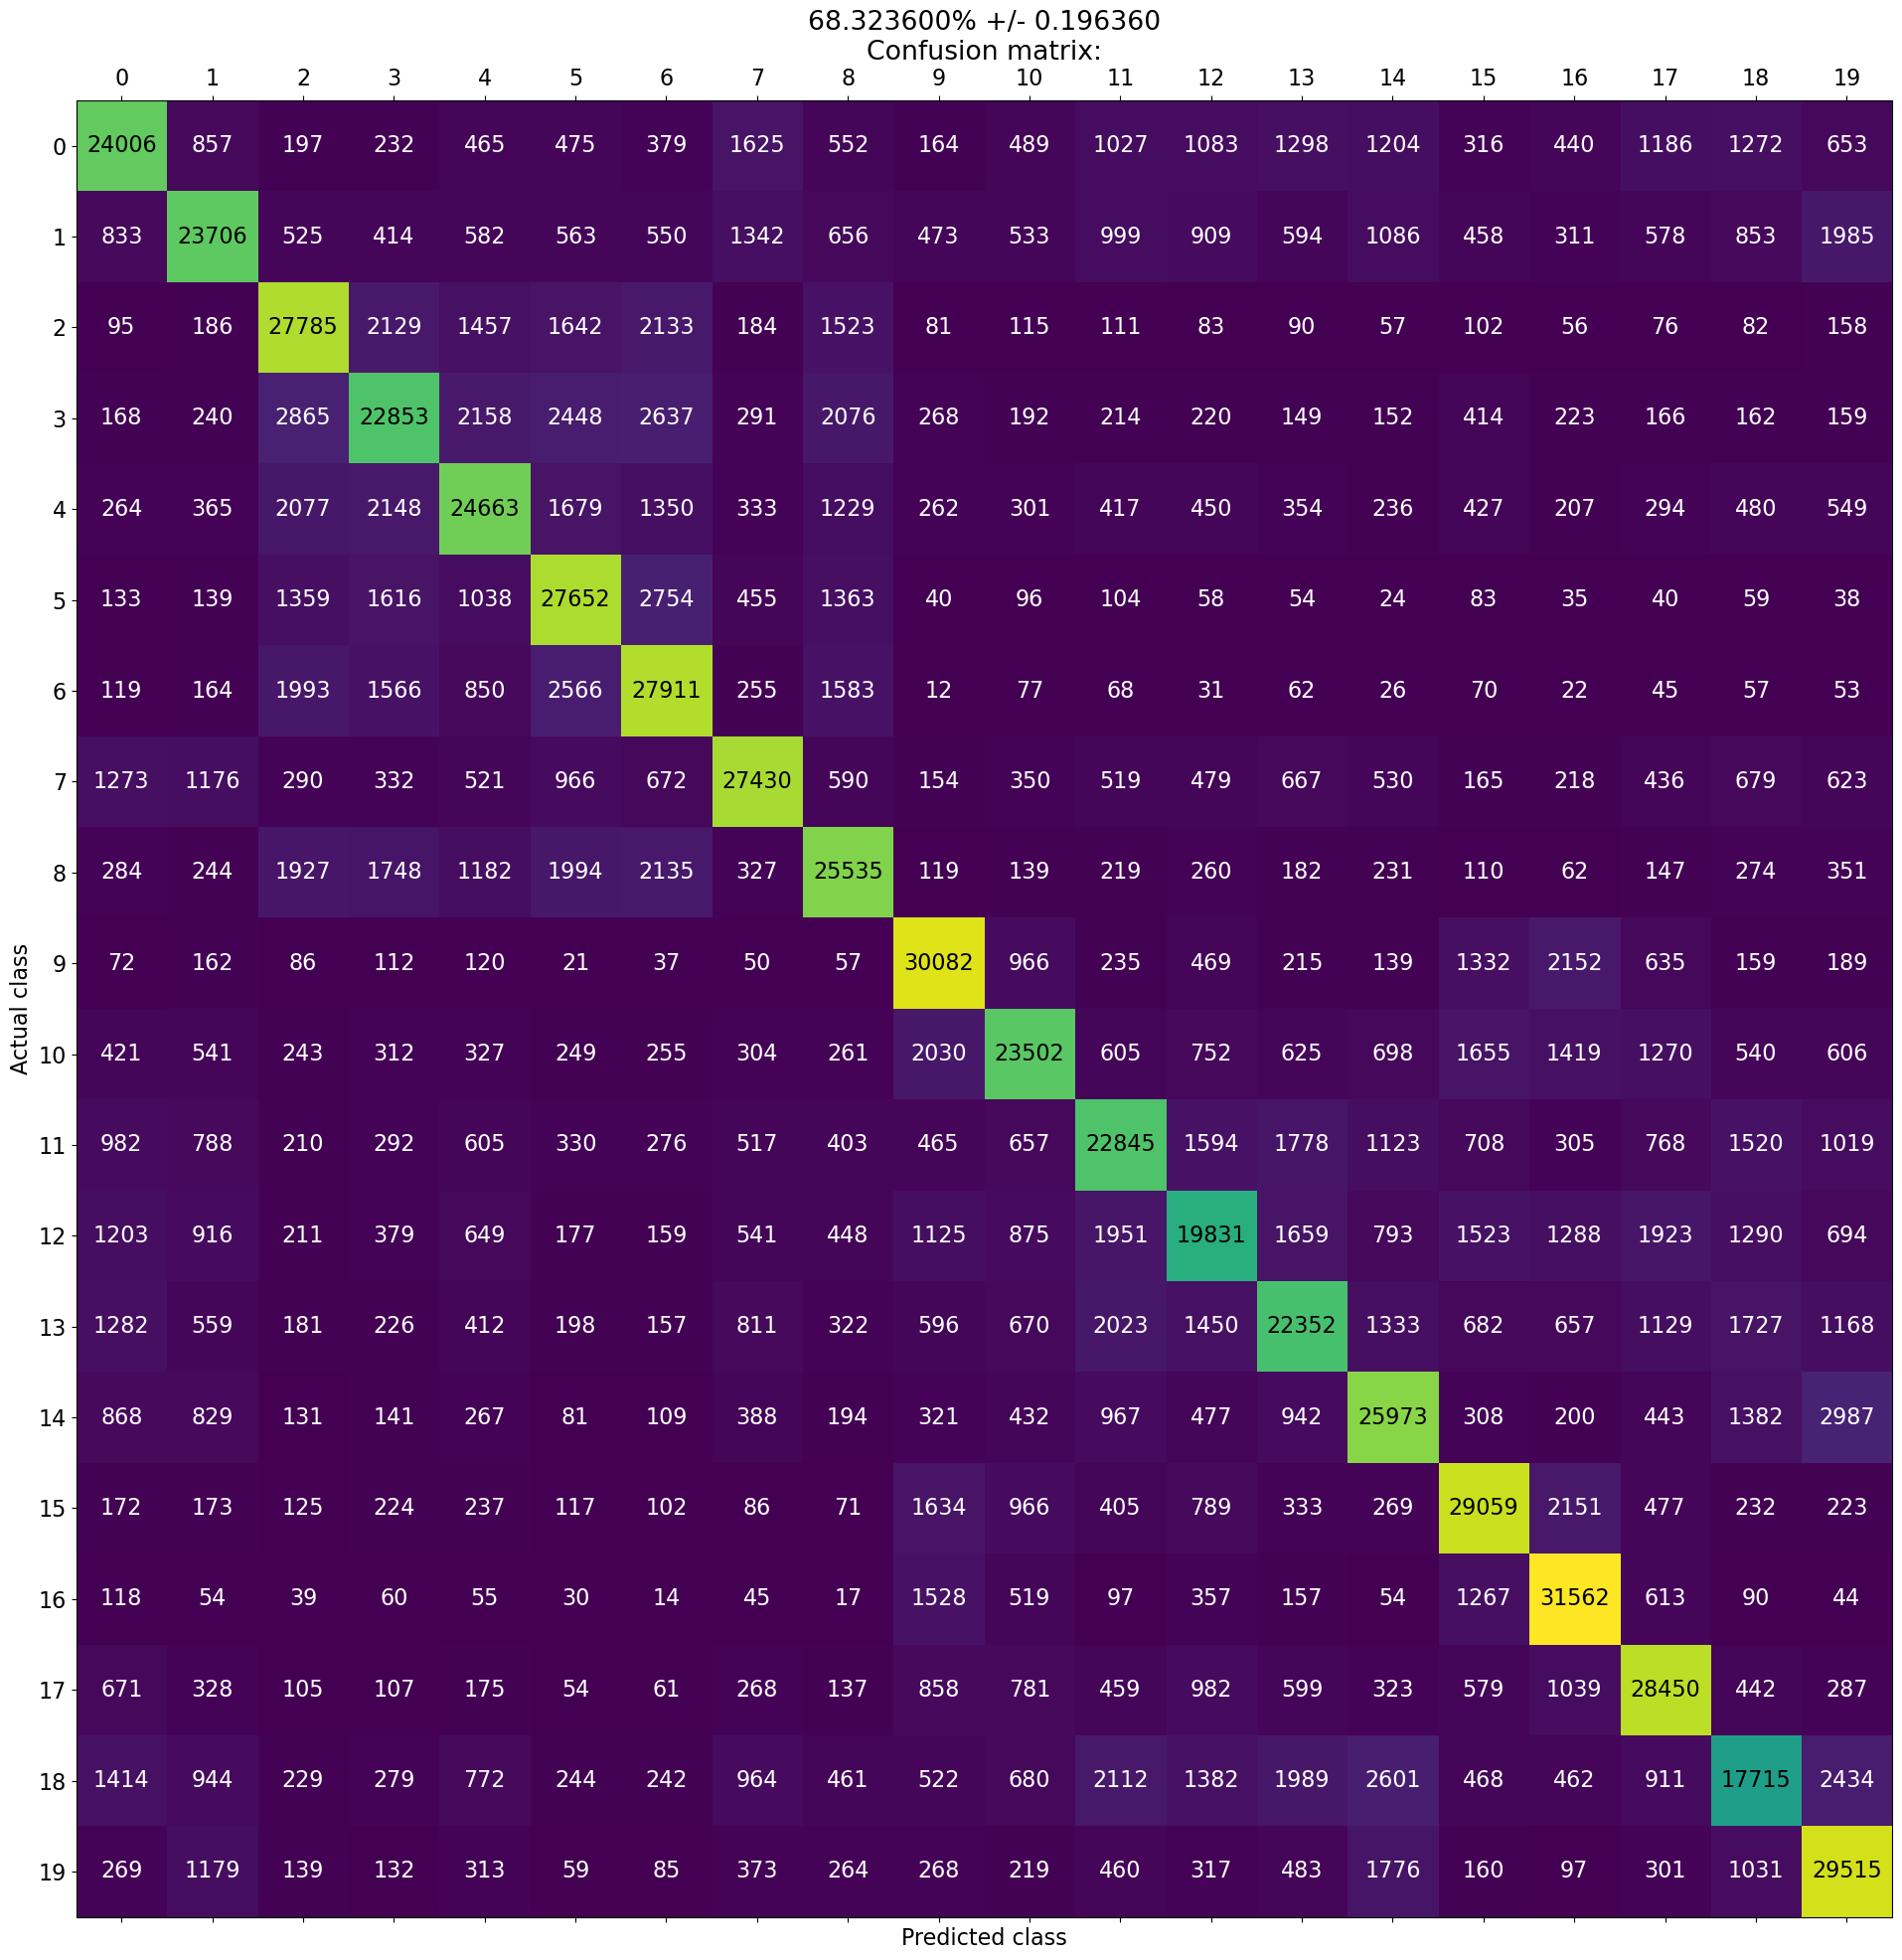

In [26]:
# Classify
all_accuracies, confusion_matrix = make_runs(test_set, test_set_counts, "inductive", compute_confusion_matrix=True)
mean_accuracy, confidence_95 = compute_accuracy_stats(all_accuracies)
plot_matrix(confusion_matrix,
            rows_labels=list(range(test_set.shape[0])),
            cols_labels=list(range(test_set.shape[0])),
            rows_title="Actual class",
            cols_title="Predicted class",
            title="%f%% +/- %f\nConfusion matrix:" % (100 * mean_accuracy, 100 * confidence_95),
            round_values=0)

We can also work in the transductive setting, where we can exploit the queries during the classificationt task. A possible classifier is the soft K-means algorithm. You can find a description of that classifier here for instance: https://arxiv.org/abs/2201.09699.

<u><b>TODO (optional, advanced):</b></u> Fill the function below to implement it.

In [ ]:
def soft_k_means (ways, x_shots, y_shots, x_queries, temperature=5) :

    ###########################################################################################################
    """
        Soft K-means algorithm.
        In:
            * ways: Possible labels.
            * x_shots: Labeled data.
            * y_shots: Labels.
            * x_queries: Unlabeled data.
        Out:
            * y_queries: Predicted labels for unlabeled data.
    """
    ###########################################################################################################

    # TODO
    
    # Done
    return y_queries

Let's use this classifier to predict labels for queries in multiple runs. For `ARGS.random_seed = 0`, we obtain the following performance:
* Backbone #1: 74.890133% +/- 0.210404
* Backbone #2: 74.228% +/- 0.209706
* Backbone #3: 74.939467% +/- 0.210941

<u><b>TODO:</b></u> Experiment various preprocessing methods, backbones, etc. in order to get the best performance you can over 10,000 runs.

In [ ]:
# Classify
all_accuracies, confusion_matrix = make_runs(test_set, test_set_counts, "transductive", compute_confusion_matrix=True)
mean_accuracy, confidence_95 = compute_accuracy_stats(all_accuracies)
plot_matrix(confusion_matrix,
            rows_labels=list(range(test_set.shape[0])),
            cols_labels=list(range(test_set.shape[0])),
            rows_title="Actual class",
            cols_title="Predicted class",
            title="%f%% +/- %f\nConfusion matrix:" % (100 * mean_accuracy, 100 * confidence_95),
            round_values=0)